### 2.2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('lc_58.6272.729.B.txt')
x = np.array(df['Time'])
y = np.array(df['Mag'])
error = np.array(df['Error'])

In [3]:
error_mean = error.mean()

In [4]:
x_cleaned = x[error <= 3 * error_mean]
y_cleaned = y[error <= 3 * error_mean]
error_cleaned = error[error <= 3 * error_mean]

In [5]:
x.shape[0] - x_cleaned.shape[0], y.shape[0] - y_cleaned.shape[0], error.shape[0] - error_cleaned.shape[0]

(18, 18, 18)

In [6]:
def normalize(array):
    return (array - array.mean()) / array.std(), array.mean(), array.std()

In [7]:
x_normalized, a1, b1 = normalize(x_cleaned)
y_normalized, a2, b2 = normalize(y_cleaned)
error_normalized = error_cleaned / b2

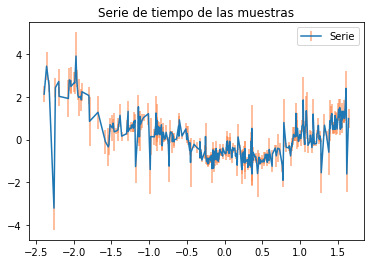

In [8]:
plt.title('Serie de tiempo de las muestras')
plt.errorbar(x_normalized, y_normalized, yerr=error_normalized, ecolor=(1.0, 0.5, 0.25, 0.5), elinewidth=2)
plt.legend(['Serie'])
plt.show()

### 2.3

In [9]:
def car_lik(parameters,t,x,error_vars):

    error_vars = error_vars**2

    x = x.astype('float64')
    t = t.astype('float64')
    error_vars = error_vars.astype('float64')

    sigma = parameters[0]
    tau = parameters[1]

    #b = parameters[1] #comment it to do 2 pars estimation
    #tau = params(1,1);
    #sigma = sqrt(2*var(x)/tau);

    b = np.mean(x)/tau

    epsilon = 1e-300
    cte_neg = -np.infty
    num_datos = np.size(x)

    Omega = []
    x_hat = []
    a = []
    x_ast = []

    Omega.append((tau*(sigma**2))/2.)
    x_hat.append(0.)
    a.append(0.)
    x_ast.append(x[0] - b*tau)

    loglik = 0.

    for i in range(1,num_datos):

        a_new = np.exp(-(t[i]-t[i-1])/tau)
        x_ast.append(x[i] - b*tau)
        x_hat.append(a_new*x_hat[i-1] + (a_new*Omega[i-1]/(Omega[i-1] + error_vars[i-1]))*(x_ast[i-1]-x_hat[i-1]))

        Omega.append(Omega[0]*(1-(a_new**2)) + ((a_new**2))*Omega[i-1]*( 1 - (Omega[i-1]/(Omega[i-1]+ error_vars[i-1]))))

        loglik_inter = -0.5*( np.log(2*np.pi*(Omega[i] + error_vars[i])) + ((x_hat[i]-x_ast[i])**2) / (Omega[i] + error_vars[i]))
                       #+ np.log(epsilon)

        loglik = loglik + loglik_inter

    return loglik

In [10]:
from scipy.stats import multivariate_normal

In [11]:
P = lambda x: car_lik(x, x_normalized, y_normalized, error_normalized)

In [12]:
taus = [1]
sigmas = [1]
likelihoods = []
alphas = []
accepted_alphas = []
N = 1000
for _ in range(N):
    last = [taus[-1], sigmas[-1]]
    Q_last = multivariate_normal(last, [[1, 0], [0, 1]])

    proposal = Q_last.rvs()
    
    Q_proposed = multivariate_normal(proposal, [[1, 0], [0, 1]])
    Q_of_last_given_prop = np.log(Q_proposed.pdf(last))
    Q_of_prop_given_last = np.log(Q_last.pdf(proposal))
    P_prop = P(proposal)
    alpha = min((Q_of_last_given_prop + P_prop) - (Q_of_prop_given_last + P(last)), 1)
    u = np.random.uniform(0, 1)
    alphas.append(alpha)
    if u < np.exp(alpha):
        taus.append(proposal[0])
        sigmas.append(proposal[1])
        likelihoods.append(P_prop)
        accepted_alphas.append(alpha)

/Users/raimundoherrera/Desktop/Envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in log


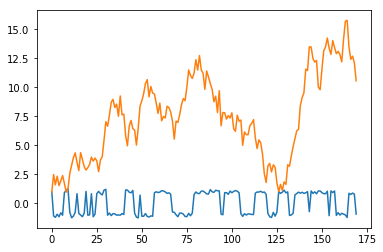

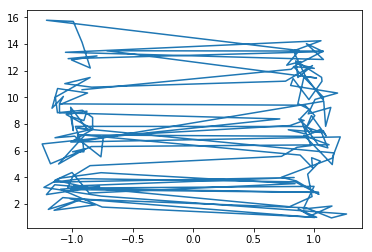

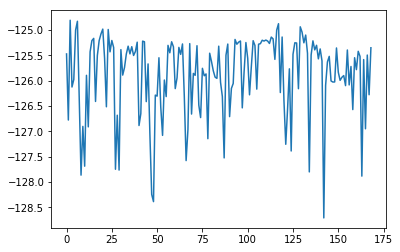

In [25]:
plt.plot(taus)
plt.plot(sigmas)
plt.show()
plt.plot(taus, sigmas)
plt.show()
plt.plot(likelihoods)
plt.show()

In [26]:
burning = 100
window = 10

In [27]:
tau = np.array(taus[burning::window]).mean()
sigma = np.array(sigmas[burning::window]).mean()

In [28]:
b = y_normalized.mean() / tau

In [29]:
tau, sigma

(0.12012948112392355, 7.613210674358301)

In [30]:
def E(t, s, X_s, tau, b):
    return np.exp(-(t - s) / tau) * X_s + b * tau * (1 - np.exp(-(t - s) / tau))

def Var(t, s, tau, sigma):
    return tau * sigma * sigma / 2 * (1 - np.exp(-(t - s) / tau))

In [31]:
E(x_normalized[4], x_normalized[3], y_normalized[3], tau, b)

-2.7493647219018245

In [32]:
Var(x_normalized[4], x_normalized[3], tau, sigma)

0.5073942398679738

In [33]:
y_normalized[4]

2.4429358201558533

In [34]:
predictions = [E(x_normalized[i + 1], x_normalized[i], y_normalized[i], tau, b) for i in range(len(x_normalized) - 1)]             
prediction_errors = [Var(x_normalized[i + 1], x_normalized[i], tau, sigma) for i in range(len(x_normalized) - 1)]

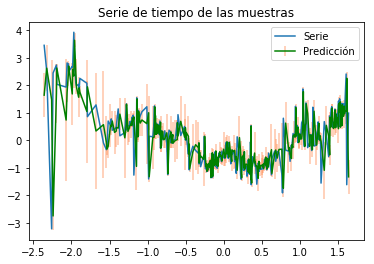

In [47]:
plt.title('Serie de tiempo de las muestras')
plt.plot(x_normalized[1:], y_normalized[1:])
plt.errorbar(x_normalized[1:], predictions, yerr=prediction_errors, c='green', ecolor=(1.0, 0.5, 0.25, 0.35), elinewidth=2)
plt.legend(['Serie', 'Predicción'])
plt.show()